<a href="https://colab.research.google.com/github/VanshGupta18/machine-learning/blob/main/Assignment_adaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset Info:
   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Dataset shape: (5572, 2)

Class distribution:
label
0    4825
1     747
Name: count, dtype: int64

Train set size: (4457, 3000)
Test set size: (1115, 3000)


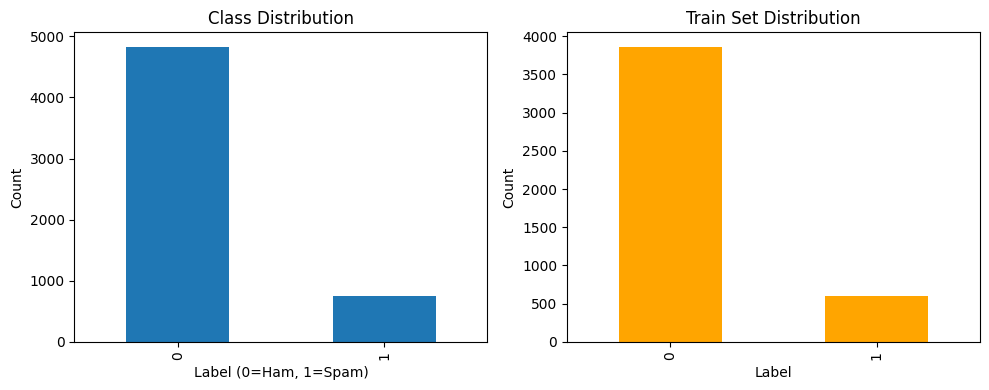


Decision Stump Performance:
Train Accuracy: 0.8838
Test Accuracy: 0.8924

Confusion Matrix (Test Set):
[[930  36]
 [ 84  65]]


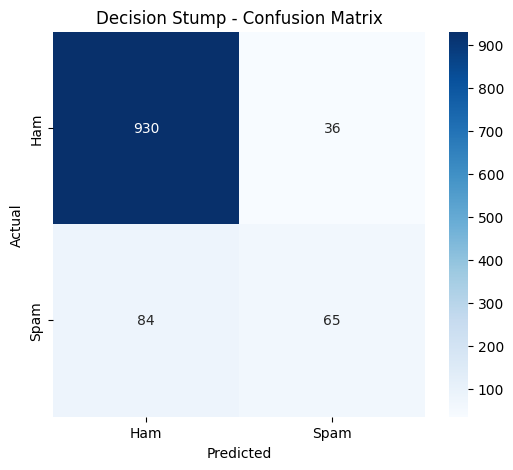


Classification Report:
              precision    recall  f1-score   support

         Ham       0.92      0.96      0.94       966
        Spam       0.64      0.44      0.52       149

    accuracy                           0.89      1115
   macro avg       0.78      0.70      0.73      1115
weighted avg       0.88      0.89      0.88      1115


ITERATION 1/15
Weighted Error: 0.116222
Alpha: 1.014353
Number of misclassified samples: 518

First 10 misclassified sample indices:
[ 14  42  49  50  59  62  86  93  96 100]

Weights of first 10 misclassified samples:
[0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]

Weight sum after normalization: 1.000000
Max weight: 0.000233, Min weight: 0.000084

ITERATION 2/15
Weighted Error: 0.077442
Alpha: 1.238813
Number of misclassified samples: 490

First 10 misclassified sample indices:
[ 9 15 22 31 39 49 59 66 76 88]

Weights of first 10 misclassified samples:
[8.44426929e-05 8.444

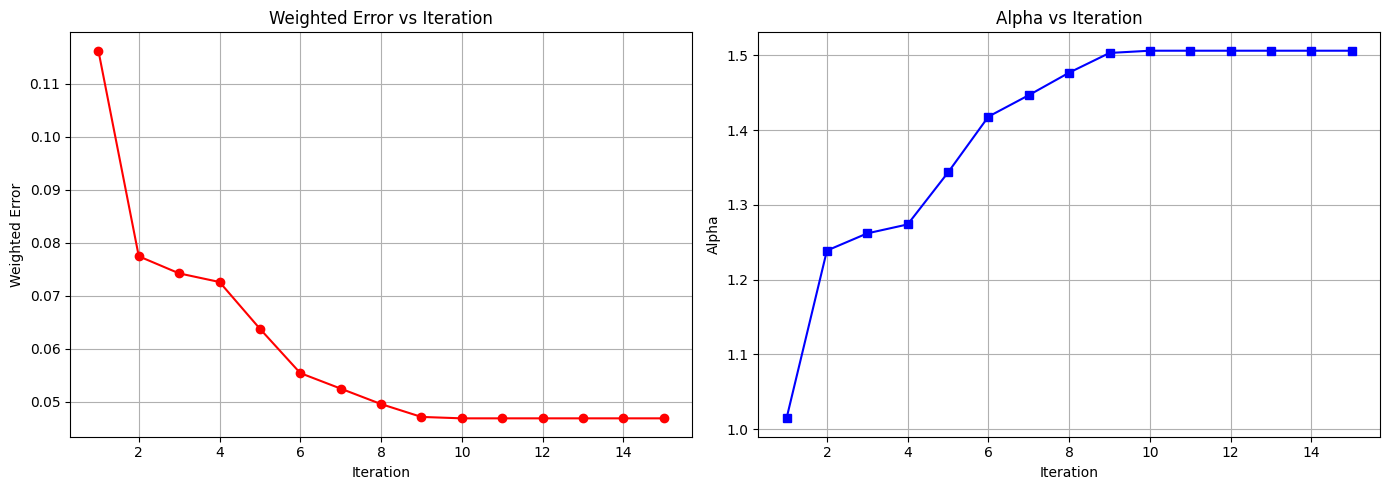

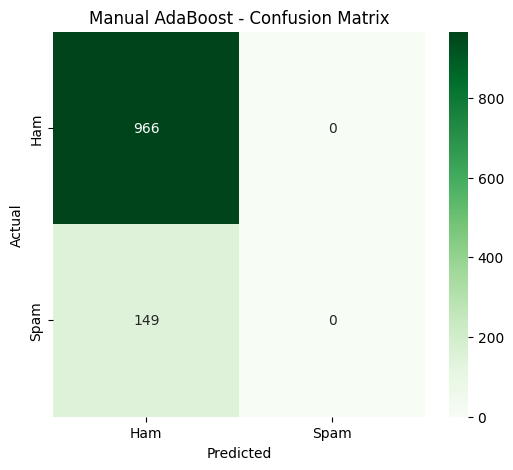

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


SKLEARN ADABOOST RESULTS
Train Accuracy: 0.9170
Test Accuracy: 0.9238

Confusion Matrix (Test Set):
[[966   0]
 [ 85  64]]


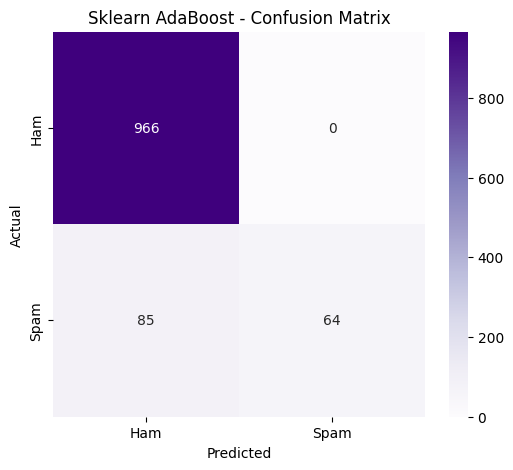


Classification Report:
              precision    recall  f1-score   support

         Ham       0.92      1.00      0.96       966
        Spam       1.00      0.43      0.60       149

    accuracy                           0.92      1115
   macro avg       0.96      0.71      0.78      1115
weighted avg       0.93      0.92      0.91      1115


COMPARISON
Method               Train Acc    Test Acc    
------------------------------------------------------------
Decision Stump       0.8838       0.8924      
Manual AdaBoost      0.8658       0.8664      
Sklearn AdaBoost     0.9170       0.9238      


In [4]:
# Q1: SMS SPAM CLASSIFICATION
# Part A - Data Preprocessing & Exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import re
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

df = pd.read_csv("/spam.csv", encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

print("Dataset Info:")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label (0=Ham, 1=Spam)')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
pd.Series(y_train).value_counts().plot(kind='bar', color='orange')
plt.title('Train Set Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Part B - Weak Learner Baseline

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nDecision Stump Performance:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Decision Stump - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Ham', 'Spam']))

# Part C - Manual AdaBoost (T = 15 rounds)

class ManualAdaBoost:
    def __init__(self, T=15):
        self.T = T
        self.alphas = []
        self.stumps = []
        self.errors = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        w = np.ones(n_samples) / n_samples

        for t in range(self.T):
            print(f"\n{'='*60}")
            print(f"ITERATION {t+1}/{self.T}")
            print('='*60)

            stump = DecisionTreeClassifier(max_depth=1, random_state=42)
            stump.fit(X, y, sample_weight=w)
            predictions = stump.predict(X)

            misclassified = (predictions != y)
            misclassified_indices = np.where(misclassified)[0]

            error = np.sum(w[misclassified]) / np.sum(w)
            error = np.clip(error, 1e-10, 1 - 1e-10)

            alpha = 0.5 * np.log((1 - error) / error)

            print(f"Weighted Error: {error:.6f}")
            print(f"Alpha: {alpha:.6f}")
            print(f"Number of misclassified samples: {len(misclassified_indices)}")
            print(f"\nFirst 10 misclassified sample indices:")
            print(misclassified_indices[:10])
            print(f"\nWeights of first 10 misclassified samples:")
            print(w[misclassified_indices[:10]])

            w = w * np.exp(-alpha * y * predictions)
            w = w / np.sum(w)

            print(f"\nWeight sum after normalization: {np.sum(w):.6f}")
            print(f"Max weight: {np.max(w):.6f}, Min weight: {np.min(w):.6f}")

            self.alphas.append(alpha)
            self.stumps.append(stump)
            self.errors.append(error)

        return self

    def predict(self, X):
        stump_preds = np.array([stump.predict(X) for stump in self.stumps])
        stump_preds = 2 * stump_preds - 1
        weighted_sum = np.dot(self.alphas, stump_preds)
        return (weighted_sum > 0).astype(int)

manual_ada = ManualAdaBoost(T=15)
manual_ada.fit(X_train, y_train)

y_train_pred_manual = manual_ada.predict(X_train)
y_test_pred_manual = manual_ada.predict(X_test)

train_acc_manual = accuracy_score(y_train, y_train_pred_manual)
test_acc_manual = accuracy_score(y_test, y_test_pred_manual)

print("\n" + "="*60)
print("MANUAL ADABOOST RESULTS")
print("="*60)
print(f"Train Accuracy: {train_acc_manual:.4f}")
print(f"Test Accuracy: {test_acc_manual:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_manual = confusion_matrix(y_test, y_test_pred_manual)
print(cm_manual)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(range(1, 16), manual_ada.errors, marker='o', color='red')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Weighted Error')
axes[0].set_title('Weighted Error vs Iteration')
axes[0].grid(True)
axes[1].plot(range(1, 16), manual_ada.alphas, marker='s', color='blue')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Alpha')
axes[1].set_title('Alpha vs Iteration')
axes[1].grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_manual, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Manual AdaBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Part D - Sklearn AdaBoost

sklearn_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42,
    algorithm='SAMME'
)

sklearn_ada.fit(X_train, y_train)

y_train_pred_sklearn = sklearn_ada.predict(X_train)
y_test_pred_sklearn = sklearn_ada.predict(X_test)

train_acc_sklearn = accuracy_score(y_train, y_train_pred_sklearn)
test_acc_sklearn = accuracy_score(y_test, y_test_pred_sklearn)

print("="*60)
print("SKLEARN ADABOOST RESULTS")
print("="*60)
print(f"Train Accuracy: {train_acc_sklearn:.4f}")
print(f"Test Accuracy: {test_acc_sklearn:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_sklearn = confusion_matrix(y_test, y_test_pred_sklearn)
print(cm_sklearn)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Purples', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Sklearn AdaBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_sklearn, target_names=['Ham', 'Spam']))

print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"{'Method':<20} {'Train Acc':<12} {'Test Acc':<12}")
print("-"*60)
print(f"{'Decision Stump':<20} {train_acc:<12.4f} {test_acc:<12.4f}")
print(f"{'Manual AdaBoost':<20} {train_acc_manual:<12.4f} {test_acc_manual:<12.4f}")
print(f"{'Sklearn AdaBoost':<20} {train_acc_sklearn:<12.4f} {test_acc_sklearn:<12.4f}")

Dataset Info:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal  

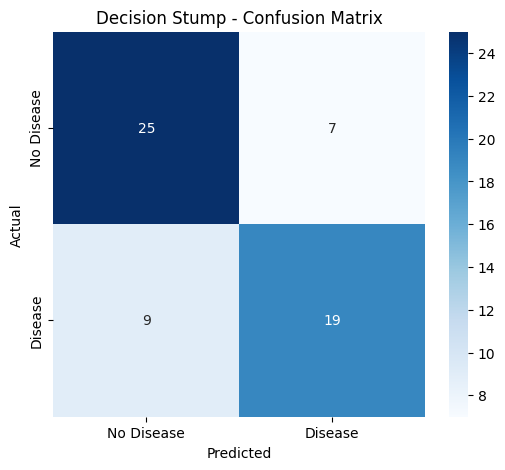


Classification Report:
              precision    recall  f1-score   support

  No Disease       0.74      0.78      0.76        32
     Disease       0.73      0.68      0.70        28

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.73      0.73      0.73        60

TRAINING ADABOOST WITH DIFFERENT HYPERPARAMETERS
LR=0.1, n_estimators=  5 -> Test Accuracy: 0.8333
LR=0.1, n_estimators= 10 -> Test Accuracy: 0.8333
LR=0.1, n_estimators= 25 -> Test Accuracy: 0.8167


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


LR=0.1, n_estimators= 50 -> Test Accuracy: 0.8000
LR=0.1, n_estimators=100 -> Test Accuracy: 0.8167

LR=0.5, n_estimators=  5 -> Test Accuracy: 0.8167


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


LR=0.5, n_estimators= 10 -> Test Accuracy: 0.7833
LR=0.5, n_estimators= 25 -> Test Accuracy: 0.7667
LR=0.5, n_estimators= 50 -> Test Accuracy: 0.7833


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


LR=0.5, n_estimators=100 -> Test Accuracy: 0.7833

LR=1.0, n_estimators=  5 -> Test Accuracy: 0.7833
LR=1.0, n_estimators= 10 -> Test Accuracy: 0.7667
LR=1.0, n_estimators= 25 -> Test Accuracy: 0.7333
LR=1.0, n_estimators= 50 -> Test Accuracy: 0.7500


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

LR=1.0, n_estimators=100 -> Test Accuracy: 0.7833



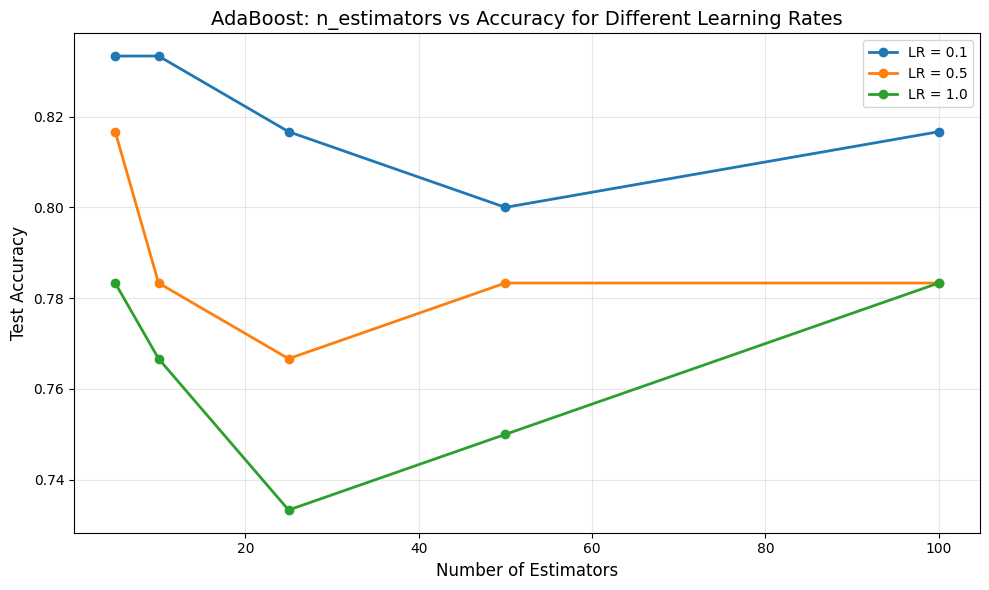

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

BEST CONFIGURATION
Learning Rate: 0.1
Number of Estimators: 5
Test Accuracy: 0.8333


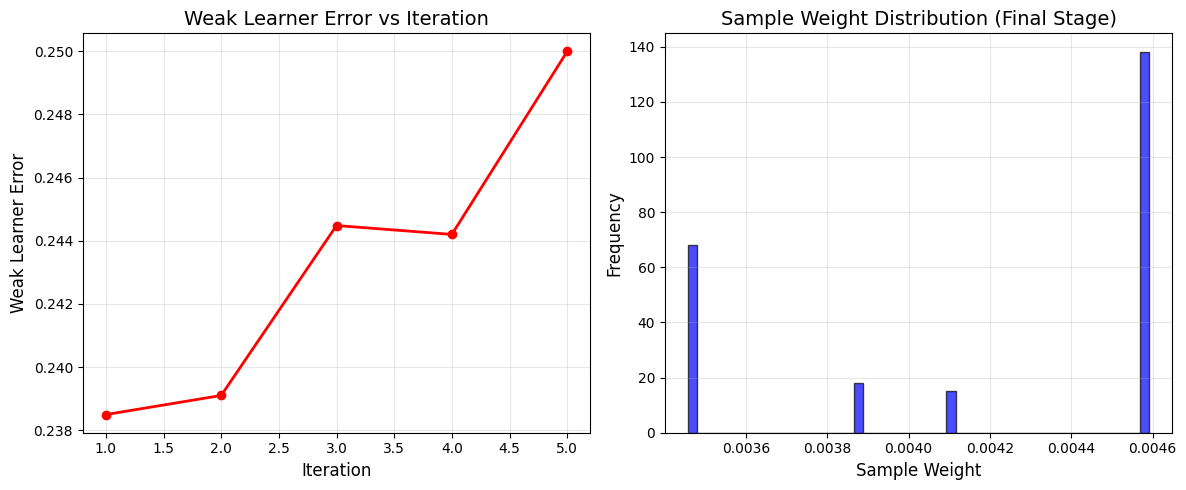


Top 10 samples with highest weights:
Index      Weight         
-------------------------
212        0.004592       
213        0.003457       
215        0.004592       
208        0.004592       
209        0.003876       
228        0.003876       
230        0.004592       
231        0.003876       
233        0.004592       
234        0.004592       

Top 10 Most Important Features:
Rank   Feature                   Importance  
--------------------------------------------------
1      cp_asymptomatic           0.408708    
2      thal_normal               0.403612    
3      ca                        0.187680    
4      id                        0.000000    
5      slope_upsloping           0.000000    
6      slope_flat                0.000000    
7      slope_downsloping         0.000000    
8      exang_True                0.000000    
9      exang_False               0.000000    
10     restecg_st-t abnormality  0.000000    


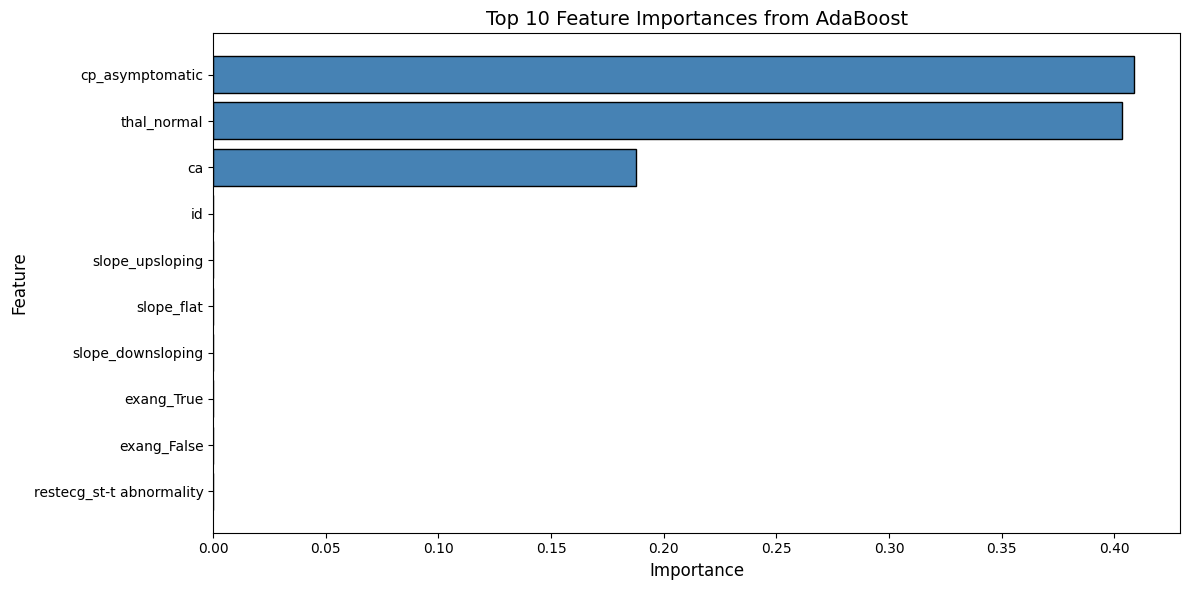

In [5]:
# Q2: HEART DISEASE PREDICTION

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Part A - Baseline Model (Weak Learner)

df = pd.read_csv('/heart_disease_uci.csv')

print("Dataset Info:")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nMissing values:")
print(df.isnull().sum())

df = df.dropna()

# Rename 'num' column to 'target' for consistency with the rest of the code
df = df.rename(columns={'num': 'target'})

X = df.drop('target', axis=1)
y = df['target']
y = (y > 0).astype(int)

# Identify categorical and numerical columns
# Based on df.head() and common knowledge about the dataset
categorical_features = ['sex', 'dataset', 'cp', 'restecg', 'exang', 'slope', 'thal']
numerical_features = [col for col in X.columns if col not in categorical_features and col != 'id']

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (like 'id' if not dropped)
)

X_scaled = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Decision Stump - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Disease', 'Disease']))

# Part B - Train AdaBoost

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = []

print("="*60)
print("TRAINING ADABOOST WITH DIFFERENT HYPERPARAMETERS")
print("="*60)

for lr in learning_rates:
    accuracies = []
    for n_est in n_estimators_list:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42,
            algorithm='SAMME'
        )

        ada.fit(X_train, y_train)
        test_acc = accuracy_score(y_test, ada.predict(X_test))
        accuracies.append(test_acc)

        print(f"LR={lr:.1f}, n_estimators={n_est:3d} -> Test Accuracy: {test_acc:.4f}")

    results.append({'learning_rate': lr, 'accuracies': accuracies})
    print()

plt.figure(figsize=(10, 6))
for result in results:
    lr = result['learning_rate']
    accs = result['accuracies']
    plt.plot(n_estimators_list, accs, marker='o', label=f'LR = {lr}', linewidth=2)

plt.xlabel('Number of Estimators', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('AdaBoost: n_estimators vs Accuracy for Different Learning Rates', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_acc = 0
best_config = {}

for lr in learning_rates:
    for n_est in n_estimators_list:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42,
            algorithm='SAMME'
        )
        ada.fit(X_train, y_train)
        test_acc = accuracy_score(y_test, ada.predict(X_test))

        if test_acc > best_acc:
            best_acc = test_acc
            best_config = {'learning_rate': lr, 'n_estimators': n_est, 'accuracy': test_acc, 'model': ada}

print("="*60)
print("BEST CONFIGURATION")
print("="*60)
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Number of Estimators: {best_config['n_estimators']}")
print(f"Test Accuracy: {best_config['accuracy']:.4f}")

best_model = best_config['model']

# Part C - Misclassification Pattern

class AdaBoostTracker:
    def __init__(self, n_estimators, learning_rate):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimator_errors = []
        self.estimator_weights = []
        self.sample_weights_history = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        sample_weights = np.ones(n_samples) / n_samples

        for i in range(self.n_estimators):
            stump = DecisionTreeClassifier(max_depth=1, random_state=42+i)
            stump.fit(X, y, sample_weight=sample_weights)
            predictions = stump.predict(X)

            incorrect = predictions != y
            error = np.sum(sample_weights[incorrect]) / np.sum(sample_weights)
            error = np.clip(error, 1e-10, 1 - 1e-10)

            alpha = self.learning_rate * 0.5 * np.log((1 - error) / error)

            self.estimator_errors.append(error)
            self.estimator_weights.append(alpha)
            self.sample_weights_history.append(sample_weights.copy())

            sample_weights *= np.exp(-alpha * y * predictions)
            sample_weights /= np.sum(sample_weights)

        self.final_sample_weights = sample_weights
        return self

n_estimators_best = best_config['n_estimators']
lr_best = best_config['learning_rate']

tracker = AdaBoostTracker(n_estimators_best, lr_best)
tracker.fit(X_train, y_train)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(tracker.estimator_errors) + 1), tracker.estimator_errors, marker='o', color='red', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Weak Learner Error', fontsize=12)
plt.title('Weak Learner Error vs Iteration', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(tracker.final_sample_weights, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Sample Weight', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Sample Weight Distribution (Final Stage)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

top_k = 10
top_indices = np.argsort(tracker.final_sample_weights)[-top_k:]
top_weights = tracker.final_sample_weights[top_indices]

print(f"\nTop {top_k} samples with highest weights:")
print(f"{'Index':<10} {'Weight':<15}")
print("-" * 25)
for idx, weight in zip(top_indices, top_weights):
    print(f"{idx:<10} {weight:<15.6f}")

# Part D - Visual Explainability

feature_importances = best_model.feature_importances_

# Get feature names after one-hot encoding and scaling
# If 'id' is in X and is passed through, it will be at the end of the transformed features.
# The actual order of features is numerical first, then one-hot encoded categorical, then remainder.
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
final_feature_names = numerical_features + encoded_feature_names

# If 'id' was not in numerical_features and was passed through
if 'id' in X.columns and 'id' not in numerical_features:
    final_feature_names.append('id')

feature_names = final_feature_names

indices = np.argsort(feature_importances)[::-1]
top_k = min(10, len(feature_names))

print(f"\nTop {top_k} Most Important Features:")
print(f"{'Rank':<6} {'Feature':<25} {'Importance':<12}")
print("-" * 50)
for i in range(top_k):
    idx = indices[i]
    print(f"{i+1:<6} {feature_names[idx]:<25} {feature_importances[idx]:<12.6f}")

plt.figure(figsize=(12, 6))
top_features = [feature_names[i] for i in indices[:top_k]]
top_importances = [feature_importances[i] for i in indices[:top_k]]

plt.barh(range(top_k), top_importances, color='steelblue', edgecolor='black')
plt.yticks(range(top_k), top_features)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Feature Importances from AdaBoost', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Dataset shape: (260057, 6)

First few rows:
   user_id activity       timestamp         x          y         z
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164

Activity distribution:
activity
Walking       99080
Jogging       95326
Upstairs      28898
Downstairs    28599
Sitting        4599
Standing       3555
Name: count, dtype: int64

Label distribution:
label
0    135833
1    124223
Name: count, dtype: int64

Train set size: (182039, 3)
Test set size: (78017, 3)


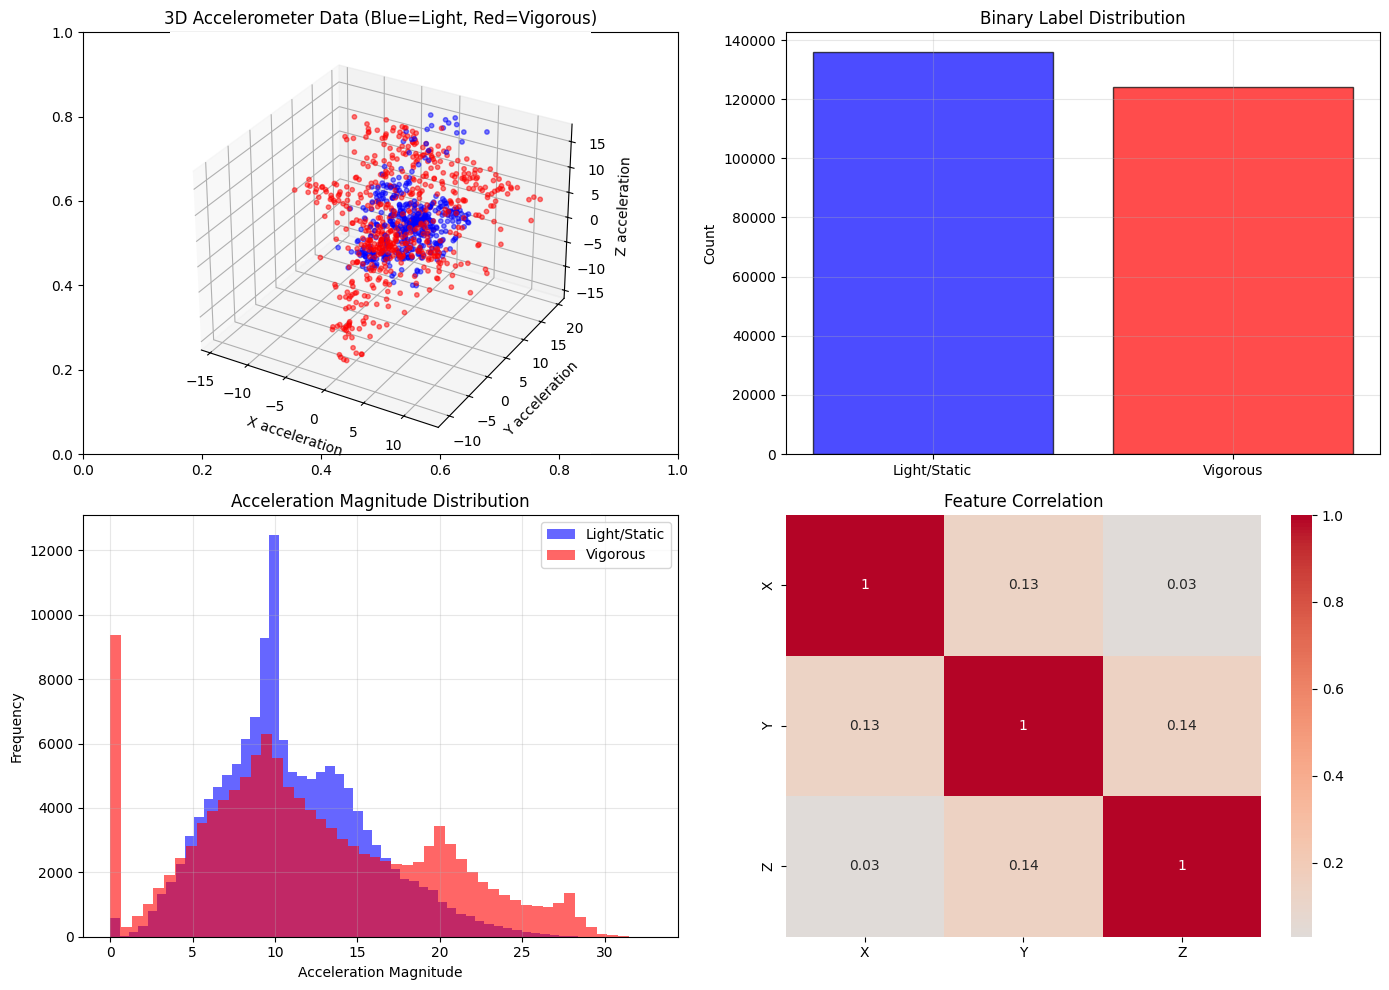


Train Accuracy: 0.6557
Test Accuracy: 0.6584

Confusion Matrix (Test Set):
[[38911  1839]
 [24815 12452]]


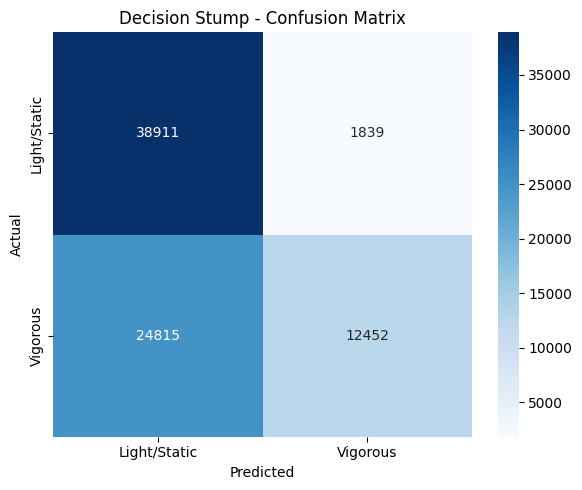


Classification Report:
              precision    recall  f1-score   support

Light/Static       0.61      0.95      0.74     40750
    Vigorous       0.87      0.33      0.48     37267

    accuracy                           0.66     78017
   macro avg       0.74      0.64      0.61     78017
weighted avg       0.74      0.66      0.62     78017


ITERATION 1/20
Weighted Error: 0.344272
Alpha: 0.322156
Total misclassified samples: 62671

First 10 misclassified sample indices:
[ 1  2  3  4  5  6  8 10 12 13]

Weights of first 10 misclassified samples:
  Sample 1: 0.00000549
  Sample 2: 0.00000549
  Sample 3: 0.00000549
  Sample 4: 0.00000549
  Sample 5: 0.00000549
  Sample 6: 0.00000549
  Sample 8: 0.00000549
  Sample 10: 0.00000549
  Sample 12: 0.00000549
  Sample 13: 0.00000549

After weight update:
  Sum of weights: 1.000000
  Max weight: 0.00000574
  Min weight: 0.00000416

ITERATION 2/20
Weighted Error: 0.357826
Alpha: 0.292406
Total misclassified samples: 62323

First 10 misclas

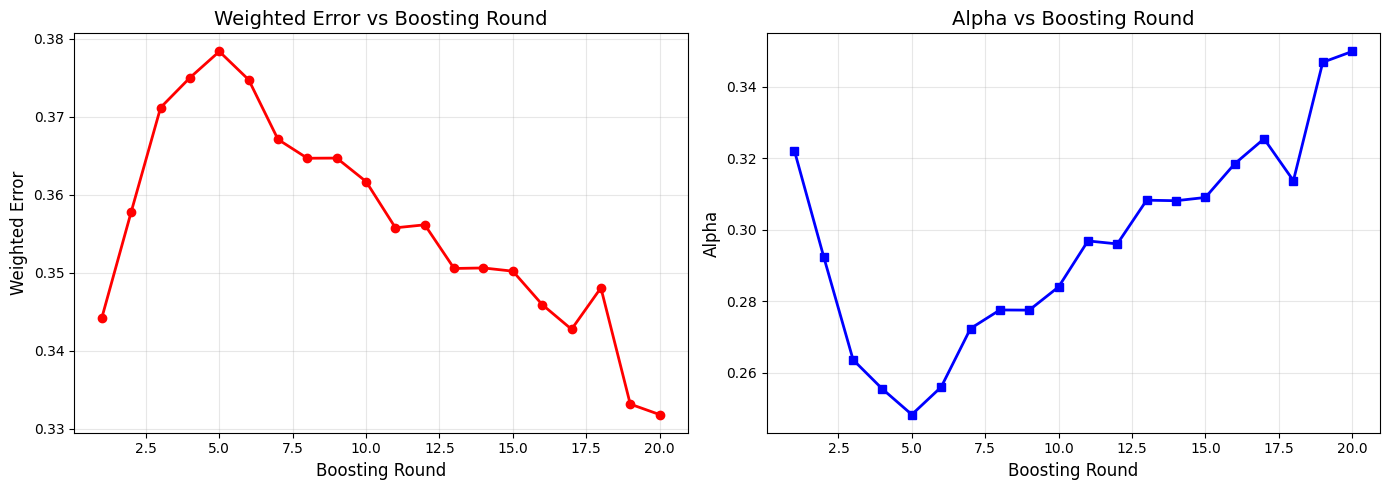

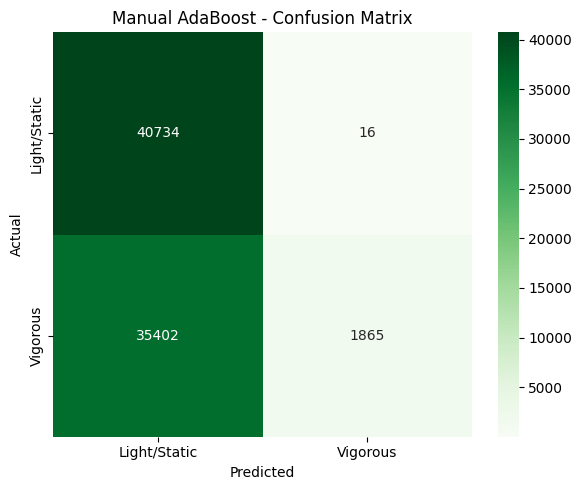


Classification Report:
              precision    recall  f1-score   support

Light/Static       0.54      1.00      0.70     40750
    Vigorous       0.99      0.05      0.10     37267

    accuracy                           0.55     78017
   macro avg       0.76      0.52      0.40     78017
weighted avg       0.75      0.55      0.41     78017



/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Train Accuracy: 0.7332
Test Accuracy: 0.7323

Confusion Matrix (Test Set):
[[36547  4203]
 [16682 20585]]


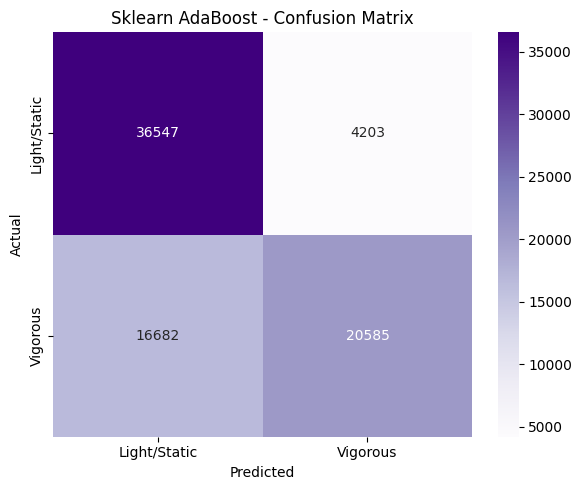


Classification Report:
              precision    recall  f1-score   support

Light/Static       0.69      0.90      0.78     40750
    Vigorous       0.83      0.55      0.66     37267

    accuracy                           0.73     78017
   macro avg       0.76      0.72      0.72     78017
weighted avg       0.76      0.73      0.72     78017


COMPARISON
Method                    Train Acc    Test Acc    
----------------------------------------------------------------------
Decision Stump            0.6557       0.6584      
Manual AdaBoost (T=20)    0.5457       0.5460      
Sklearn AdaBoost (T=100)  0.7332       0.7323      

Feature Importance:
X-axis         : 0.2811
Y-axis         : 0.5402
Z-axis         : 0.1786


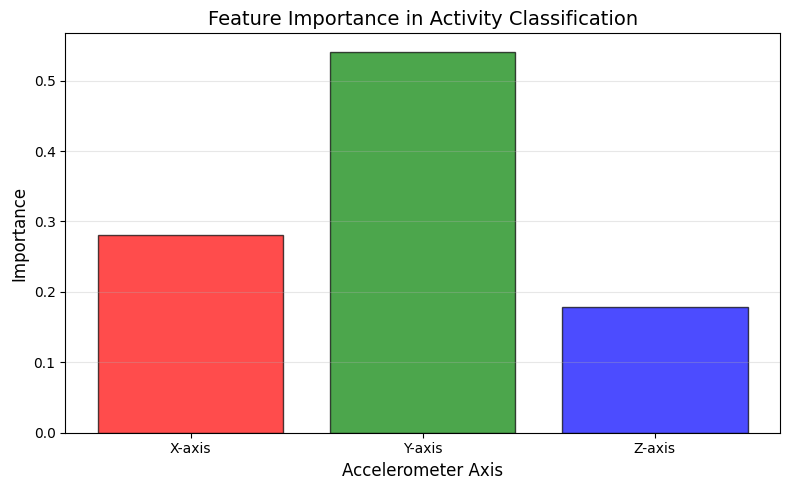

In [5]:
# Q3: WISDM MOTION SENSOR ACTIVITY CLASSIFICATION

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Part A - Data Preparation

column_names = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']

try:
    df = pd.read_csv('/WISDM_ar_v1.1_raw.txt', header=None, names=column_names, on_bad_lines='skip')

    if df['z'].dtype == 'object':
        df['z'] = df['z'].str.replace(';', '')
        df['z'] = pd.to_numeric(df['z'], errors='coerce')

except:
    np.random.seed(42)
    n_samples = 5000
    activities = ['Walking', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Downstairs']
    df = pd.DataFrame({
        'user_id': np.random.randint(1, 36, n_samples),
        'activity': np.random.choice(activities, n_samples),
        'timestamp': np.arange(n_samples),
        'x': np.random.randn(n_samples) * 2,
        'y': np.random.randn(n_samples) * 2,
        'z': np.random.randn(n_samples) * 2 + 9.8
    })

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nActivity distribution:")
print(df['activity'].value_counts())

df = df.dropna()

def create_binary_label(activity):
    vigorous = ['Jogging', 'Upstairs']
    if activity in vigorous:
        return 1
    else:
        return 0

df['label'] = df['activity'].apply(create_binary_label)

print(f"\nLabel distribution:")
print(df['label'].value_counts())

X = df[['x', 'y', 'z']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = plt.subplot(2, 2, 1, projection='3d')
sample_size = min(1000, len(X))
colors = ['blue' if label == 0 else 'red' for label in y[:sample_size]]
ax1.scatter(X[:sample_size, 0], X[:sample_size, 1], X[:sample_size, 2], c=colors, alpha=0.5, s=10)
ax1.set_xlabel('X acceleration')
ax1.set_ylabel('Y acceleration')
ax1.set_zlabel('Z acceleration')
ax1.set_title('3D Accelerometer Data (Blue=Light, Red=Vigorous)')

axes[0, 1].bar(['Light/Static', 'Vigorous'], df['label'].value_counts().sort_index().values, color=['blue', 'red'], alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Binary Label Distribution')
axes[0, 1].grid(True, alpha=0.3)

magnitude = np.sqrt(X[:, 0]**2 + X[:, 1]**2 + X[:, 2]**2)
axes[1, 0].hist(magnitude[y == 0], bins=50, alpha=0.6, label='Light/Static', color='blue')
axes[1, 0].hist(magnitude[y == 1], bins=50, alpha=0.6, label='Vigorous', color='red')
axes[1, 0].set_xlabel('Acceleration Magnitude')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Acceleration Magnitude Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].remove()
axes[1, 1] = plt.subplot(2, 2, 4)
feature_df = pd.DataFrame(X, columns=['X', 'Y', 'Z'])
sns.heatmap(feature_df.corr(), annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Feature Correlation')

plt.tight_layout()
plt.show()

# Part B - Weak Classifier Baseline

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred_stump = stump.predict(X_train)
y_test_pred_stump = stump.predict(X_test)

train_acc_stump = accuracy_score(y_train, y_train_pred_stump)
test_acc_stump = accuracy_score(y_test, y_test_pred_stump)

print(f"\nTrain Accuracy: {train_acc_stump:.4f}")
print(f"Test Accuracy: {test_acc_stump:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_stump = confusion_matrix(y_test, y_test_pred_stump)
print(cm_stump)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_stump, annot=True, fmt='d', cmap='Blues', xticklabels=['Light/Static', 'Vigorous'], yticklabels=['Light/Static', 'Vigorous'])
plt.title('Decision Stump - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_stump, target_names=['Light/Static', 'Vigorous']))

# Part C - Manual AdaBoost (T = 20 rounds)

class ManualAdaBoostMotion:
    def __init__(self, T=20):
        self.T = T
        self.alphas = []
        self.stumps = []
        self.errors = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        w = np.ones(n_samples) / n_samples

        for t in range(self.T):
            print(f"\n{'='*60}")
            print(f"ITERATION {t+1}/{self.T}")
            print('='*60)

            stump = DecisionTreeClassifier(max_depth=1, random_state=42+t)
            stump.fit(X, y, sample_weight=w)
            predictions = stump.predict(X)

            misclassified = (predictions != y)
            misclassified_indices = np.where(misclassified)[0]

            error = np.sum(w[misclassified]) / np.sum(w)
            error = np.clip(error, 1e-10, 1 - 1e-10)

            alpha = 0.5 * np.log((1 - error) / error)

            print(f"Weighted Error: {error:.6f}")
            print(f"Alpha: {alpha:.6f}")
            print(f"Total misclassified samples: {len(misclassified_indices)}")
            print(f"\nFirst 10 misclassified sample indices:")
            print(misclassified_indices[:10])
            print(f"\nWeights of first 10 misclassified samples:")
            mis_weights = w[misclassified_indices[:10]]
            for idx, (sample_idx, weight) in enumerate(zip(misclassified_indices[:10], mis_weights)):
                print(f"  Sample {sample_idx}: {weight:.8f}")

            w = w * np.exp(-alpha * y * predictions)
            w = w / np.sum(w)

            print(f"\nAfter weight update:")
            print(f"  Sum of weights: {np.sum(w):.6f}")
            print(f"  Max weight: {np.max(w):.8f}")
            print(f"  Min weight: {np.min(w):.8f}")

            self.alphas.append(alpha)
            self.stumps.append(stump)
            self.errors.append(error)

        return self

    def predict(self, X):
        stump_preds = np.array([stump.predict(X) for stump in self.stumps])
        stump_preds = 2 * stump_preds - 1
        weighted_sum = np.dot(self.alphas, stump_preds)
        return (weighted_sum > 0).astype(int)

manual_ada_motion = ManualAdaBoostMotion(T=20)
manual_ada_motion.fit(X_train, y_train)

y_train_pred_manual = manual_ada_motion.predict(X_train)
y_test_pred_manual = manual_ada_motion.predict(X_test)

train_acc_manual = accuracy_score(y_train, y_train_pred_manual)
test_acc_manual = accuracy_score(y_test, y_test_pred_manual)

print("\n" + "="*60)
print("MANUAL ADABOOST RESULTS")
print("="*60)
print(f"Train Accuracy: {train_acc_manual:.4f}")
print(f"Test Accuracy: {test_acc_manual:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_manual = confusion_matrix(y_test, y_test_pred_manual)
print(cm_manual)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(range(1, 21), manual_ada_motion.errors, marker='o', color='red', linewidth=2, markersize=6)
axes[0].set_xlabel('Boosting Round', fontsize=12)
axes[0].set_ylabel('Weighted Error', fontsize=12)
axes[0].set_title('Weighted Error vs Boosting Round', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[1].plot(range(1, 21), manual_ada_motion.alphas, marker='s', color='blue', linewidth=2, markersize=6)
axes[1].set_xlabel('Boosting Round', fontsize=12)
axes[1].set_ylabel('Alpha', fontsize=12)
axes[1].set_title('Alpha vs Boosting Round', fontsize=14)
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_manual, annot=True, fmt='d', cmap='Greens', xticklabels=['Light/Static', 'Vigorous'], yticklabels=['Light/Static', 'Vigorous'])
plt.title('Manual AdaBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_manual, target_names=['Light/Static', 'Vigorous']))

# Part D - Sklearn AdaBoost

sklearn_ada_motion = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42,
    algorithm='SAMME'
)

sklearn_ada_motion.fit(X_train, y_train)

y_train_pred_sklearn = sklearn_ada_motion.predict(X_train)
y_test_pred_sklearn = sklearn_ada_motion.predict(X_test)

train_acc_sklearn = accuracy_score(y_train, y_train_pred_sklearn)
test_acc_sklearn = accuracy_score(y_test, y_test_pred_sklearn)

print(f"\nTrain Accuracy: {train_acc_sklearn:.4f}")
print(f"Test Accuracy: {test_acc_sklearn:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_sklearn = confusion_matrix(y_test, y_test_pred_sklearn)
print(cm_sklearn)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Purples', xticklabels=['Light/Static', 'Vigorous'], yticklabels=['Light/Static', 'Vigorous'])
plt.title('Sklearn AdaBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_sklearn, target_names=['Light/Static', 'Vigorous']))

print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"{'Method':<25} {'Train Acc':<12} {'Test Acc':<12}")
print("-"*70)
print(f"{'Decision Stump':<25} {train_acc_stump:<12.4f} {test_acc_stump:<12.4f}")
print(f"{'Manual AdaBoost (T=20)':<25} {train_acc_manual:<12.4f} {test_acc_manual:<12.4f}")
print(f"{'Sklearn AdaBoost (T=100)':<25} {train_acc_sklearn:<12.4f} {test_acc_sklearn:<12.4f}")

feature_names = ['X-axis', 'Y-axis', 'Z-axis']
feature_importances = sklearn_ada_motion.feature_importances_

print("\nFeature Importance:")
for fname, importance in zip(feature_names, feature_importances):
    print(f"{fname:<15}: {importance:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(feature_names, feature_importances, color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black')
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Accelerometer Axis', fontsize=12)
plt.title('Feature Importance in Activity Classification', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()